In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [3]:
from spectral_clustering import *
from PixelEM import *

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [4]:
18,29,47

(18, 29, 47)

working on obj 1 for 2 clusters
working on obj 4 for 2 clusters
working on obj 7 for 2 clusters
working on obj 8 for 3 clusters
working on obj 10 for 2 clusters
working on obj 20 for 5 clusters


/home/jlee782/.local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


working on obj 15 for 2 clusters
working on obj 18 for 2 clusters
working on obj 21 for 2 clusters
working on obj 22 for 2 clusters
working on obj 25 for 2 clusters
working on obj 26 for 2 clusters
working on obj 27 for 4 clusters
working on obj 28 for 2 clusters
working on obj 29 for 3 clusters
working on obj 30 for 2 clusters
working on obj 31 for 3 clusters
working on obj 32 for 2 clusters
working on obj 33 for 2 clusters
working on obj 34 for 2 clusters
working on obj 37 for 2 clusters


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


working on obj 40 for 2 clusters
working on obj 41 for 2 clusters
working on obj 42 for 2 clusters
working on obj 47 for 3 clusters


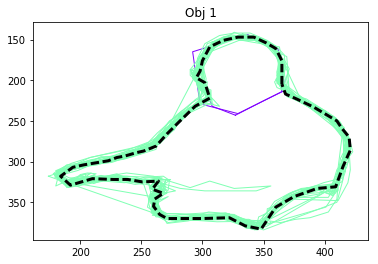

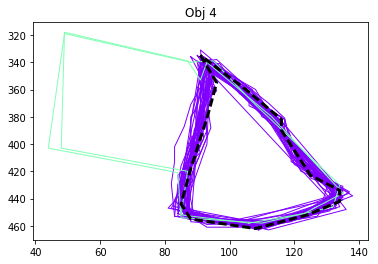

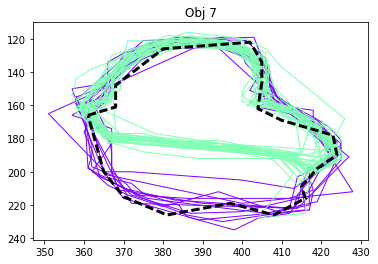

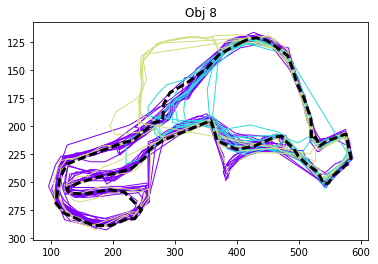

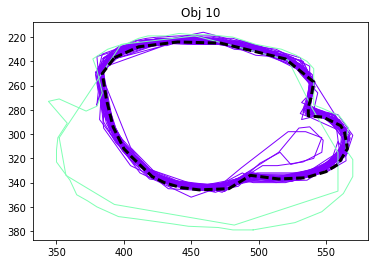

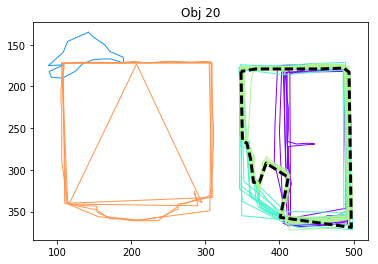

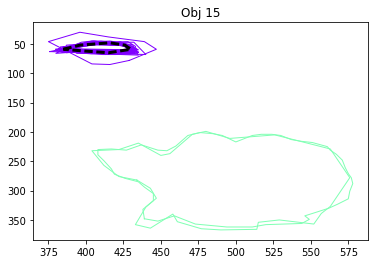

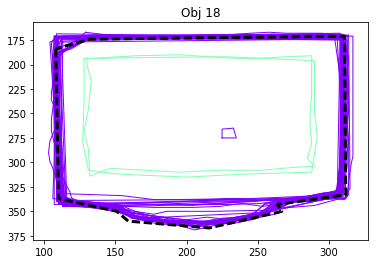

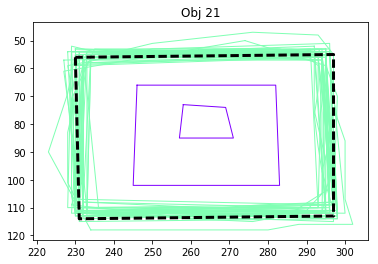

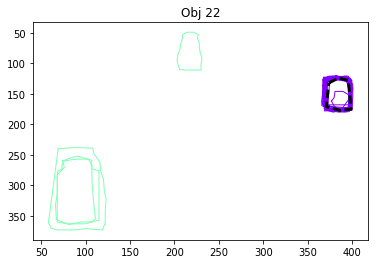

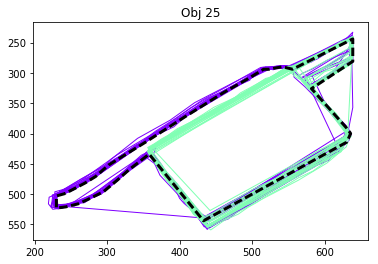

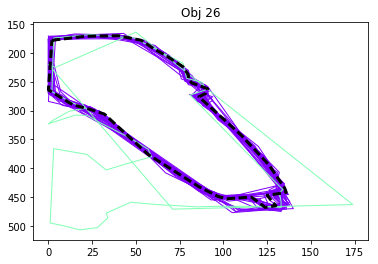

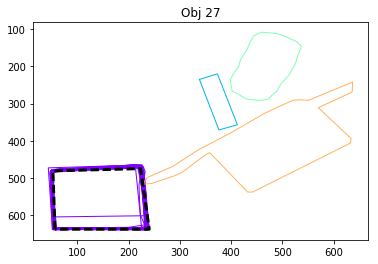

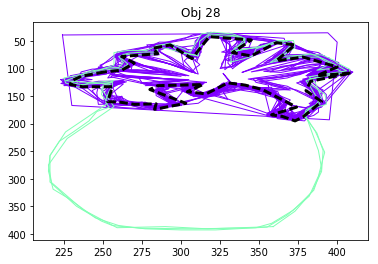

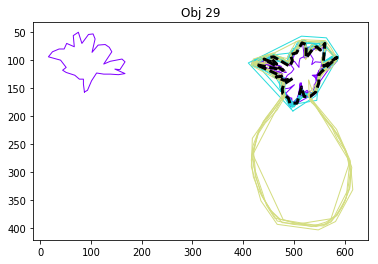

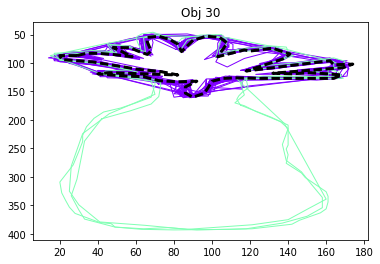

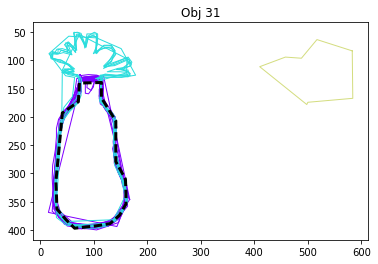

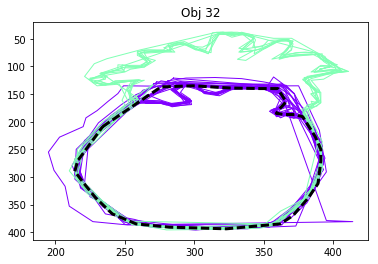

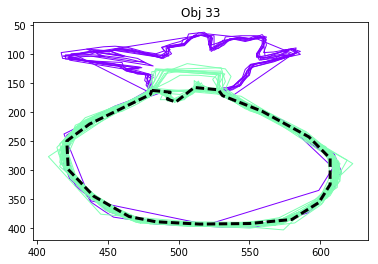

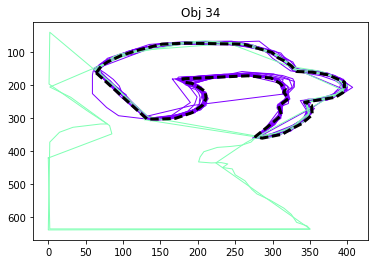

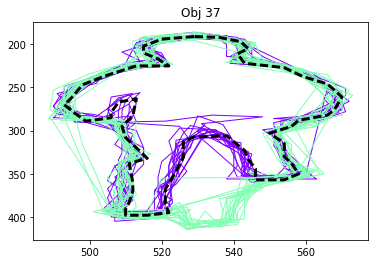

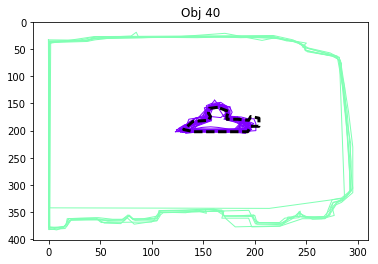

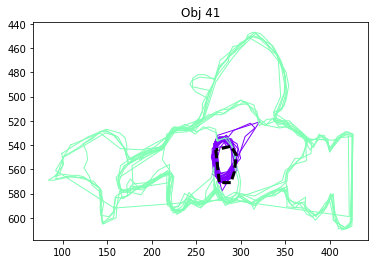

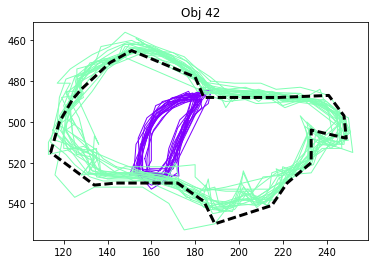

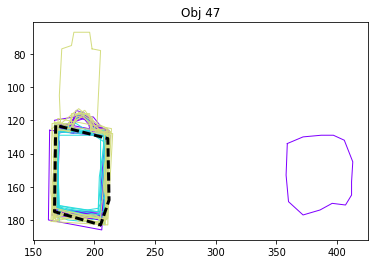

In [5]:
objN_lst = [(1,2),(4,2),(7,2),(8,3),(10,2),(20,5),(15,2),(18,2),(21,2),(22,2),(25,2),(26,2),(27,4),(28,2),(29,3),(30,2),(31,3),(32,2),(33,2),(34,2),(37,2),(40,2),(41,2),(42,2),(47,3)]
# objN_lst = [(18,2)]#,(29,3),(47,3)]
obj_worker_clusters =[]
for objN in objN_lst:
    print "working on obj {} for {} clusters".format(objN[0],objN[1])
    obj_worker_cluster = run_spectral_clustering(objN[0],objN[1])
    obj_worker_clusters.extend(obj_worker_cluster)

for each cluster 

In [118]:
clust_df = pd.DataFrame(obj_worker_clusters,columns=["objid","wid","cluster"])

In [134]:
import json
data_df = []
for sample in sample_specs.keys():
    for objid in clust_df.objid.unique():
        workers = json.load(open("pixel_em/{}/obj{}/worker_ids.json".format(sample,objid)))
        for w in workers:
            try:
                cluster_id = clust_df[(clust_df["objid"]==objid)&(clust_df["wid"]==w)]["cluster"].values[0]
            except:
                print "can not find : {}; {}".format(objid,w)
            data_df.append([sample,objid,w,cluster_id])

can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139
can not find : 10; 139


In [136]:
clust_df  = pd.DataFrame(data_df,columns=["sample","objid","wid","clust"])